# Data Mining Techniques Project
## Playground

In [1]:
%matplotlib inline
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

In [2]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Downloading data

First we read the Dataset into a pandas DataFrame and since we can expect Rownumber and Surname to not be important to our model we can simply delete these columns from the DataFrame. Next we transform the Column 'Gender' into a binary variable, because the models can not handle strings as input.

In [4]:
df = pd.read_csv("Churn_Modelling.csv", index_col=[1])
del df['RowNumber']
del df['Surname']

df.Gender[df.Gender == 'Male'] = 1
df.Gender[df.Gender == 'Female'] = 0
df.sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15681758,525,Spain,0,25,10,0.00,2,1,0,69361.95,0
15578671,706,Spain,0,29,1,209490.21,1,1,1,133267.69,1
15568519,534,France,1,41,9,0.00,2,1,0,13871.34,0
15624437,825,Spain,0,32,1,0.00,2,1,1,42935.15,0
15603554,513,France,0,45,0,164649.52,3,1,0,49915.52,1
15768763,562,France,1,37,2,0.00,1,0,1,52525.15,1
15806808,834,Germany,0,57,8,112281.60,3,1,0,140225.14,1
15713559,473,Germany,0,32,5,146602.25,2,1,1,72946.95,0
15642098,622,Spain,0,36,0,108960.00,2,1,0,111180.30,1


Here we check for missing values to see, if we need to impute anything.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


In [6]:
print('Data has missing values: ', df.isnull().values.any())

Data has missing values:  False


Then we transform the column 'Geography' into three different binary variables ('Spain', 'France', 'Germany') to fit the model.

In [7]:
enc = OneHotEncoder()
geo = enc.fit_transform(df['Geography'].values.reshape(-1, 1))
df = df.join(pd.DataFrame(geo.toarray(), index=df.index, columns=enc.categories_[0]))

Determining the explanatory and target variables and splitting into training and testing datasets.

In [8]:
expl = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'France', 'Germany', 'Spain']
x = df[expl]
y = df[['Exited']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
CustomerId,,,,,,,,,,,,
15634602,619,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
15647311,608,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
15619304,502,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
15701354,699,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
15737888,850,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


Lastly we give a brief overview of the number of people to churn in our dataset: 20.37%.

In [9]:
df.groupby('Exited').count()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
Exited,,,,,,,,,,,,,
0,7963,7963,7963,7963,7963,7963,7963,7963,7963,7963,7963,7963,7963
1,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037


# Model: RandomForestClassifier

We chose the RandomForestClassifier from sklearn over other models like MLPClassifier, LogisticRegression or a VotingClassifier. Over a few test runs we received far better results for the RFC (e.g. >85% Accuracy), whereas the results for the other models fell short of that (e.g. 75-80%).

First we are looking for a scoring system to use to obtain a good model. In this case we tried out precision, recall and accuracy score. Precision is a coefficient that indicates how cost efficient we will be by not spending money on customers who weren't going to churn in the first place. Recall is a coefficient that indicates how much revenue we could be able to retain by predicting an as high as possible fraction of customers who were going to churn. The goal is to maximize both those numbers.

We run the RFC over a wide array of parameters, while keeping the time cost low to receive an indication of the scores we are to receive.

In [10]:
clf = RandomForestClassifier(n_estimators=30)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'max_depth': [3, 5, 10, 15, 20],
    'max_features': [3, 5, 8, 12]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [11]:
def grid_search_wrapper(refit_score='precision_score'):
    
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train.values, y_train.values)

    y_pred = grid_search.predict(x_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

Precision score parameters, confusion matrix and scoring table:

In [12]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split']].round(3).head()

Best params for precision_score
{'max_depth': 3, 'min_samples_split': 5, 'max_features': 3}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      1621         2
pos       334        43


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split
1,0.931,0.136,0.818,3,3,5
2,0.924,0.142,0.819,3,3,10
0,0.922,0.134,0.818,3,3,3
5,0.851,0.266,0.838,3,5,10
13,0.851,0.323,0.848,5,3,5


Recall score parameters, confusion matrix and scoring table:

In [13]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split']].round(3).head()

Best params for recall_score
{'max_depth': 20, 'min_samples_split': 5, 'max_features': 8}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      1560        63
pos       197       180


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split
55,0.719,0.501,0.855,20,8,5
59,0.725,0.498,0.856,20,12,10
56,0.736,0.498,0.858,20,8,10
46,0.713,0.493,0.854,15,12,5
44,0.746,0.493,0.860,15,8,10


Accuracy score parameters, confusion matrix and scoring table:

In [14]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_accuracy_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split']].round(3).head()

Best params for accuracy_score
{'max_depth': 10, 'min_samples_split': 3, 'max_features': 5}

Confusion matrix of Random Forest optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg      1577        46
pos       214       163


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split
27,0.780,0.477,0.863,10,5,3
32,0.765,0.480,0.861,10,8,10
28,0.771,0.468,0.860,10,5,5
37,0.762,0.473,0.860,15,3,5
26,0.793,0.442,0.860,10,3,10


Obviously we should not use precision as our scoring system due to its abysmal resulting recall score. The decision wether to use recall or accuracy will give similar results. Due to lacking exact costs from the marketing department we can not reliably say that one scoring system is better than the other. For simplicity we are simply going to use accuracy score.

Now that we found our model we are looking to find the optimal parameters for the RFC via GridSearchCV.
By looking at the parameters for the best results in the previous step, we can run a more specific search with similar parameters.

In [19]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [3, 5, 10], 
    'max_depth': [8, 10, 12, 14, 16],
    'max_features': [3, 4, 6, 8]
}

grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
rfc = grid_search_clf.best_estimator_

Best params for accuracy_score
{'max_depth': 12, 'min_samples_split': 5, 'max_features': 4, 'n_estimators': 50}

Confusion matrix of Random Forest optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg      1582        41
pos       210       167


Here we give out GridSearchCV's best_estimator_ and its Training and Testing Scores.

In [27]:
print(rfc)
pred_train_rfc = rfc.predict_proba(x_train)
pred_test_rfc = rfc.predict_proba(x_test)

acc_train_rfc = accuracy_score(y_train, np.argmax(pred_train_rfc, 1))
acc_test_rfc = accuracy_score(y_test, np.argmax(pred_test_rfc, 1))
print("RFC: Training Accuracy:", round(acc_train_rfc, 5), "Testing Accuracy:", round(acc_test_rfc, 5))
prc_train_rfc = precision_score(y_train, np.argmax(pred_train_rfc, 1))
prc_test_rfc = precision_score(y_test, np.argmax(pred_test_rfc, 1))
print("RFC: Training Precision:", round(prc_train_rfc, 5), "Testing Precision:", round(prc_test_rfc, 5))
rec_train_rfc = recall_score(y_train, np.argmax(pred_train_rfc, 1))
rec_test_rfc = recall_score(y_test, np.argmax(pred_test_rfc, 1))
print("RFC: Training Recall:", round(rec_train_rfc, 5), "Testing Recall:", round(rec_test_rfc, 5))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RFC: Training Accuracy: 0.92025 Testing Accuracy: 0.8745
RFC: Training Precision: 0.95871 Testing Precision: 0.80288
RFC: Training Recall: 0.64337 Testing Recall: 0.44297


Confusion Matrix:

In [28]:
cnf = confusion_matrix(y_test, np.argmax(pred_test_rfc, 1))
print("RFC Confusion Matrix: \n",cnf)

RFC Confusion Matrix: 
 [[1582   41]
 [ 210  167]]


We end up getting a model with good both precision and recall, considering our previous calculations trying to maximize either one of them.

Now here is the ROC curve of the RFC:

In [29]:
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, pred_test_rfc[:, 1])
rfc_roc_auc = auc(rfc_fpr, rfc_tpr)

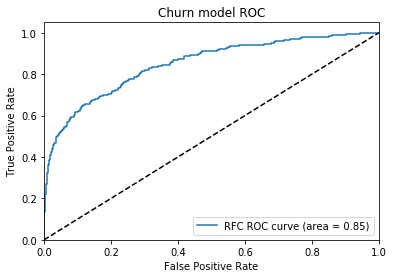

In [30]:
plt.figure()
plt.plot(rfc_fpr, rfc_tpr, label='RFC ROC curve (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Churn model ROC")
plt.legend(loc="lower right")
plt.show()

We show which are the most important variables for our RFC:

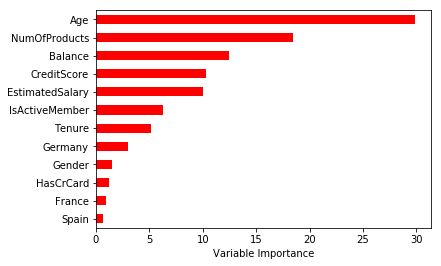

In [31]:
Importance = pd.DataFrame({'Importance': rfc.feature_importances_*100}, index=x.columns)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

And finally we give out one of the DecisionTrees of the RandomForest as an example.

In [32]:
import graphviz
from sklearn.tree import export_graphviz

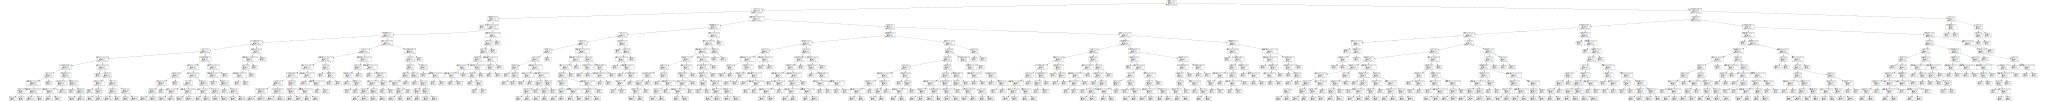

In [33]:
dot_graph = export_graphviz(rfc.estimators_[0], out_file=None, feature_names=x_train.columns)
tree_graph = graphviz.Source(dot_graph)
tree_graph